In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from model import GazeGan
from dataset import Dataset
from torch.utils.data import DataLoader
from utils import crop


In [2]:
import tensorflow as tf

2023-05-31 00:23:09.677783: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-31 00:23:09.711408: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 00:23:10.279764: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf_path = "./pretrained/pretrained"
init_vars = tf.train.list_variables(tf_path)
init_vars
# Dx, Dy, Gr, Gx, Gy, encode, vgg_16

[('Dx/d1/d0/biases', [32]),
 ('Dx/d1/d0/sn_u', [32, 96]),
 ('Dx/d1/d0/w', [4, 4, 6, 32]),
 ('Dx/d1/d1/biases', [64]),
 ('Dx/d1/d1/sn_u', [64, 512]),
 ('Dx/d1/d1/w', [4, 4, 32, 64]),
 ('Dx/d1/d2/biases', [128]),
 ('Dx/d1/d2/sn_u', [128, 1024]),
 ('Dx/d1/d2/w', [4, 4, 64, 128]),
 ('Dx/d1/d3/biases', [256]),
 ('Dx/d1/d3/sn_u', [256, 2048]),
 ('Dx/d1/d3/w', [4, 4, 128, 256]),
 ('Dx/d1/d4/biases', [256]),
 ('Dx/d1/d4/sn_u', [256, 4096]),
 ('Dx/d1/d4/w', [4, 4, 256, 256]),
 ('Dx/d1/fp/Matrix', [1024, 256]),
 ('Dx/d1/fp/bias', [256]),
 ('Dx/d1/fp/sn_u', [256, 1024]),
 ('Dx/d2/d0/biases', [32]),
 ('Dx/d2/d0/sn_u', [32, 48]),
 ('Dx/d2/d0/w', [4, 4, 3, 32]),
 ('Dx/d2/d1/biases', [64]),
 ('Dx/d2/d1/sn_u', [64, 512]),
 ('Dx/d2/d1/w', [4, 4, 32, 64]),
 ('Dx/d2/d2/biases', [128]),
 ('Dx/d2/d2/sn_u', [128, 1024]),
 ('Dx/d2/d2/w', [4, 4, 64, 128]),
 ('Dx/d2/d3/biases', [256]),
 ('Dx/d2/d3/sn_u', [256, 2048]),
 ('Dx/d2/d3/w', [4, 4, 128, 256]),
 ('Dx/d2/d4/biases', [256]),
 ('Dx/d2/d4/sn_u', [256, 4096

In [4]:
tf_vars = []
for name, shape in init_vars:
    array = tf.train.load_variable(tf_path, name)
    tf_vars.append((name, array))

In [5]:
model = GazeGan(version="V1")

In [6]:
for name, array in tf_vars:
    component_name = name[:name.find("/")]

    try:
        pointer = getattr(model, component_name)
    except AttributeError:
        print("Skipping {}".format(name))
        continue

    name = name.split("/")
    if name[-1] == "sn_u":
        continue

    for i, m_name in enumerate(name[1:]):
        if m_name == "FC1" or m_name == "FC2":
            l = [m_name]
        elif component_name == "Dx" and i == 1 and m_name[-1].isdigit():
            l = [m_name[:-1], int(m_name[-1])]
        elif component_name in ["Gr", "Gx"] and i == 0 and m_name[-1].isdigit():
            l = [m_name[:-1], int(m_name[-1])]
        else:
            l = [m_name]
        
        if len(l) == 1:
            if l[0] == "conv":
                pointer = getattr(pointer, "conv2d_first")
            elif l[0] == "output_conv":
                pointer = getattr(pointer, "conv2d_final")
            elif l[0] == "IN":
                pointer = getattr(pointer, "in_first")
            elif l[0] == "FC1":
                pointer = getattr(pointer, "fc1")
            elif l[0] == "FC2":
                pointer = getattr(pointer, "fc2")
            elif l[0] == 'Matrix' or l[0] == 'scale' or l[0] == 'w':
                pointer = getattr(pointer, 'weight')
                if len(array.shape) == 4:
                    array = array.transpose(3, 2, 0, 1)
                else:
                    array = array.transpose()
            elif l[0] == 'bias' or l[0] == 'offset' or l[0] == 'biases':
                pointer = getattr(pointer, 'bias')
            else:
                pointer = getattr(pointer, l[0])
            
        elif len(l) == 2:
            if l[0] == "conv":
                pointer = getattr(pointer, "conv2d_base")[l[1]]
            elif l[0] == "IN":
                pointer = getattr(pointer, "in_base")[l[1]]
            elif l[0] == "deconv":
                pointer = getattr(pointer, "deconv_base")[l[1]]
            elif l[0] == "IN_":
                pointer = getattr(pointer, "in_deconv_base")[l[1]]
            elif l[0] == "d":
                pointer = getattr(pointer, "conv2d_base")[l[1]]
    
    try:
        assert pointer.shape == array.shape
    except AssertionError as e:
        e.args += (pointer.shape, array.shape)
        raise
    print("Initialize PyTorch weight {}".format(name))
    pointer.data = torch.from_numpy(array)


Initialize PyTorch weight ['Dx', 'd1', 'd0', 'biases']
Initialize PyTorch weight ['Dx', 'd1', 'd0', 'w']
Initialize PyTorch weight ['Dx', 'd1', 'd1', 'biases']
Initialize PyTorch weight ['Dx', 'd1', 'd1', 'w']
Initialize PyTorch weight ['Dx', 'd1', 'd2', 'biases']
Initialize PyTorch weight ['Dx', 'd1', 'd2', 'w']
Initialize PyTorch weight ['Dx', 'd1', 'd3', 'biases']
Initialize PyTorch weight ['Dx', 'd1', 'd3', 'w']
Initialize PyTorch weight ['Dx', 'd1', 'd4', 'biases']
Initialize PyTorch weight ['Dx', 'd1', 'd4', 'w']
Initialize PyTorch weight ['Dx', 'd1', 'fp', 'Matrix']
Initialize PyTorch weight ['Dx', 'd1', 'fp', 'bias']
Initialize PyTorch weight ['Dx', 'd2', 'd0', 'biases']
Initialize PyTorch weight ['Dx', 'd2', 'd0', 'w']
Initialize PyTorch weight ['Dx', 'd2', 'd1', 'biases']
Initialize PyTorch weight ['Dx', 'd2', 'd1', 'w']
Initialize PyTorch weight ['Dx', 'd2', 'd2', 'biases']
Initialize PyTorch weight ['Dx', 'd2', 'd2', 'w']
Initialize PyTorch weight ['Dx', 'd2', 'd3', 'biases

In [7]:
for module in model.modules():
    if isinstance(module, nn.BatchNorm2d):
        module.track_running_stats = False

In [8]:
model

GazeGan(
  (Gr): ContentEncoder(
    (conv2d_first): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (in_first): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (lrelu): LeakyReLU(negative_slope=0.2)
    (conv2d_base): ModuleList(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (in_base): ModuleList(
      (0): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (fc1): Linear(in_features=8192, out_features=256, bias=True)
  )
  (Gx): GazeCorrection(
    (conv2d_first): Conv2d(6, 16, kernel_size=(7, 7), stri

In [9]:
Gr = model.Gr
Gx = model.Gx
Dx = model.Dx

In [10]:
train_set = Dataset(split="train")
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4, collate_fn=train_set.collate_fn)

In [11]:
batch = next(iter(train_loader))
x, x_mask, x_left_pos, x_right_pos = batch.values()

In [12]:
x.shape, x_mask.shape

(torch.Size([4, 3, 256, 256]), torch.Size([4, 1, 256, 256]))

In [13]:
xc = x * (1 - x_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


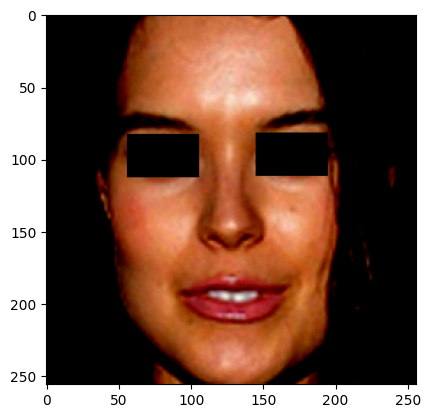

In [14]:
plt.imshow(xc[0].permute(1, 2, 0).numpy())

In [15]:
x_left_eye, x_right_eye = crop(x, x_left_pos, x_right_pos)

In [16]:
xr = model.inpaiting(x, x_mask, x_left_eye, x_right_eye)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


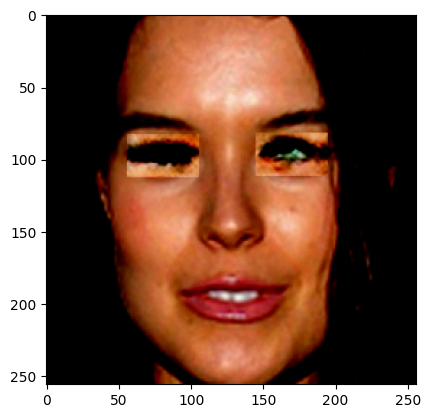

In [17]:
plt.imshow(xr[0].permute(1, 2, 0).detach().numpy())

In [18]:
xr_left_eye, xr_right_eye = crop(xr, x_left_pos, x_right_pos)

In [19]:
dx_logits = Dx(x, x_left_eye, x_right_eye)
gx_logits = Dx(xr, xr_left_eye, xr_right_eye)

In [20]:
dx_logits, gx_logits

(tensor([[-0.0125],
         [-0.0034],
         [-0.0090],
         [-0.0071]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0133],
         [ 0.0007],
         [-0.0059],
         [-0.0060]], grad_fn=<AddmmBackward0>))

In [21]:
torch.save(model.state_dict(), "./pretrained/checkpointv1.pt")